# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

pd.set_option("display.max_rows", None, "display.max_columns", None)

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

np.random.seed(42)

# Dataset Information
[Source](https://archive.ics.uci.edu/dataset/45/heart+disease)

> This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them.  In particular, the Cleveland database is the only one that has been used by ML researchers to date.  The "goal" field refers to the presence of heart disease in the patient.  It is integer valued from 0 (no presence) to 4. Experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0).  
> 
> The names and social security numbers of the patients were recently removed from the database, replaced with dummy values.
>
> One file has been "processed", that one containing the Cleveland database.  All four unprocessed files also exist in this directory.
>
> To see Test Costs (donated by Peter Turney), please see the folder "Costs"
>
> Variables Used:
> #3 age, #4 sex, #9 cp, #10 trestbps, #12 chol, #16 fbs, #19 restecg, #32 thalach, #38 exang, #40 oldpeak, #41 slope, #44 ca, #51 thal, #58 num (the predicted attribute)

## Data Cleaning

In [2]:
# # import the data by basic R
# hd_new = dict() # maybe transform this into DataFrame() later if built
# names = ["id", "ccf", "age", "sex", "painloc", "painexer", "relres", "pncaden", "cp", "trestbps", "htn", "chol", "smoke", "cigs", "years", "fbs", "dm", "famhist", "restecg", "ekgmo", "ekgday", "ekgyr", "dig", "prop", "nitr", "pro", "diuretic", "proto", "thaldur", "thaltime", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "dummy", "trestbpd", "exang", "xhypo", "oldpeak", "slope", "rldv5", "rldv5e", "ca", "restckm", "exerckm", "restef", "restwm", "exeref", "exerwm", "thal", "thalsev", "thalpul", "earlobe", "cmo", "cday", "cyr", "num", "lmt", "ladprox", "laddist", "diag", "cxmain", "ramus", "om1", "om2", "rcaprox", "rcadist", "lvx1", "lvx2", "lvx3", "lvx4", "lvf", "cathef", "junk", "name"]
# for name in names:
#     hd_new[name] = []
# # read cleveland.data into hd_new
# index = 0
# with open('heart_disease\\cleveland.data', 'r', errors='ignore') as new_hd:
#     for line in new_hd:
#         if len(hd_new['id']) > 282: # from 283th label the .data file is corrupted somehow
#             break
#         new_line = line[:-1].split(sep = ' ')
#         for i in range(len(new_line)):
#             hd_new[names[(index + i) % 76]].append(new_line[i])
#         index += len(new_line)
#         index %= 76
# for name in names:
#     hd_new[name] = hd_new[name][:282]

The manual process of reading these data takes many effort where there are corrupted files in which the data is not maintained in the universal form, thus the author is using the processed data, in which only the 14 most popular attributes are kept.

In [3]:
names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
read = lambda path: pd.read_csv(path, sep=',', names = names, na_values = '?')
cl = read("heart_disease\\processed.cleveland.data")
hg = read("heart_disease\\processed.hungarian.data")
sw = read("heart_disease\\processed.switzerland.data")
va = read("heart_disease\\processed.va.data")
hd = pd.concat([cl, hg, sw, va]).reset_index(drop=True)
hd.tail(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
915,54.0,0.0,4.0,127.0,333.0,1.0,1.0,154.0,0.0,0.0,NaN,NaN,NaN,1
916,62.0,1.0,1.0,NaN,139.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
917,55.0,1.0,4.0,122.0,223.0,1.0,1.0,100.0,0.0,0.0,NaN,NaN,6.0,2
918,58.0,1.0,4.0,NaN,385.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0
919,62.0,1.0,2.0,120.0,254.0,0.0,2.0,93.0,1.0,0.0,NaN,NaN,NaN,1


All 920 cases are read successfully. There are NA values in 10 columns. We should view how each column matters in determining whether a patient has the heart disease before deciding which cleaning method we're applying to them. Notably, counting the value of chol, we discovered 172 cases are assigned a value of 0, which is impossible. Also there is impossible 0 values in the column trestbps. An NA is assigned to such noisy data before we perform correlation calculation.

In [4]:
# cleaning noisy values
hd.loc[hd['chol'] == 0.0, 'chol'] = pd.NA
hd.loc[hd['trestbps'] == 0.0, 'trestbps'] = pd.NA
hd.loc[hd['num'] >= 1.0, 'num'] = 1.0 # this is our goal, >= 1.0 are all indicating the presence of heart disease

# counting NA values
for name in names:
    NA_count = 920 - hd[name].count()
    if NA_count > 0:
        print(f'Column "{name}" has {NA_count} NA values.')

Column "trestbps" has 60 NA values.
Column "chol" has 202 NA values.
Column "fbs" has 90 NA values.
Column "restecg" has 2 NA values.
Column "thalach" has 55 NA values.
Column "exang" has 55 NA values.
Column "oldpeak" has 62 NA values.
Column "slope" has 309 NA values.
Column "ca" has 611 NA values.
Column "thal" has 486 NA values.


<Axes: >

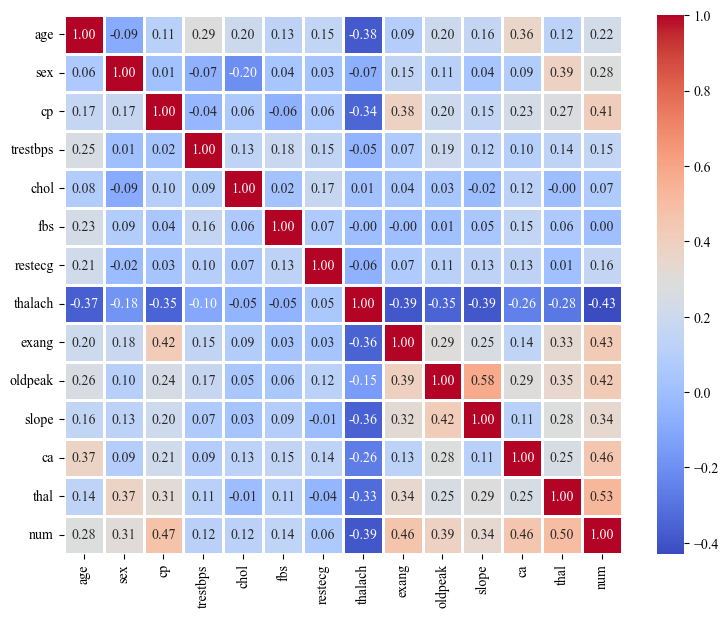

In [5]:
corr_matrix = hd.corr(method = 'pearson')
hd_noNA = hd.dropna()
corr_noNA = hd_noNA.corr(method = 'pearson')
for i in range(len(names)):
    for j in range(i, len(names)):
        # to get rid of annoying 1.0:
        # if i == j:
        #     corr_matrix[names[i]][names[j]] = 0 
        #     continue
        corr_matrix.loc[names[i], names[j]] = corr_noNA.loc[names[i], names[j]]
plt.figure(figsize = (9,7))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 1)

The Pearson correlation coefficients of the original dataset and the dataset without any rows including NAs are shown above and below the diagonal in the heatmap respectively. We can see relatively high correlations (≥0.40) from cp, chol, oldpeak, ca and thal to num. It is noteworthy that correlation coefficient from several columns (names, etc.) to num has gone under a huge change after dropping NA values. Thus we're considering to impute rather than drop. 

Principle: For many of these columns, impute iteratively by IterativeImputer() and also create a column indicating missing values. For restecg, 2 NAs are small proportion to the whole dataset, hence would not make a huge impact as dropped.

In [6]:
# restecg has 2 NAs, hence we drop
hdnew = hd.dropna(subset=['restecg',]).reset_index(drop=True)
# implement IterativeImputer with flag
flag_cols = ['trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
for col in flag_cols:
    hdnew[f'{col}_na_flag'] = hdnew[col].isna().astype(int)
imp = IterativeImputer(max_iter = 10, random_state = 42, initial_strategy = 'mean')
hd_imp = pd.DataFrame(imp.fit_transform(hdnew[flag_cols]), columns = [col + '_imputed' for col in flag_cols])
# remapping the iteratively imputed values to categorical ones
for col in ['fbs', 'exang', 'slope', 'ca', 'thal']:
    hd_imp[col + '_imputed'] = np.round(hd_imp[col + '_imputed'])
hd_imp.loc[hd_imp['thal_imputed'] <= 4.5, 'thal_imputed'] = 3.0
hd_imp.loc[np.logical_and(hd_imp['thal_imputed'] <= 6.5, hd_imp['thal_imputed'] > 4.5), 'thal_imputed'] = 6.0
hd_imp.loc[hd_imp['thal_imputed'] > 6.5, 'thal_imputed'] = 7.0
hdnew = pd.concat([hdnew, hd_imp], axis = 1)

In [7]:
dtypes = [np.int32, np.int8, 'category', np.int32, np.int32, np.int8, 'category', np.int32, np.int8, np.float32, 'category', 'category', 'category', np.int8] + [np.int8,] * 9 + [np.float32, np.float32, np.int8, np.float32, np.int8, np.float32, 'category', 'category', 'category']
names = hdnew.columns
for i in range(len(names)):
    if names[i] not in flag_cols:
        hdnew[names[i]] = hdnew[names[i]].astype(dtypes[i])
hdnew = hdnew.drop(columns = flag_cols)

**Check how much the distribution of columns changed after imputation.**

Text(0, 0.5, 'Frequency')

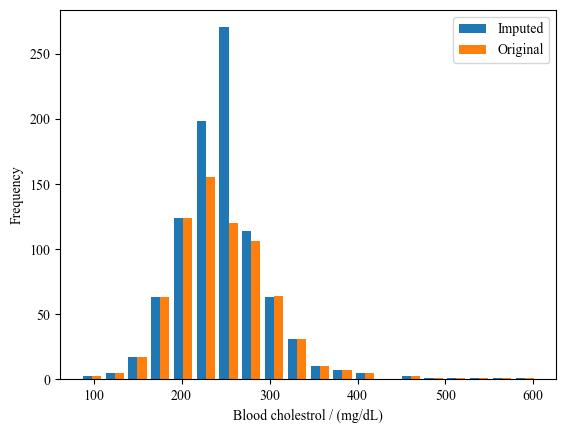

In [8]:
plt.hist([hdnew['chol_imputed'], hd['chol']], bins = 20, label = ['Imputed', 'Original'])
plt.legend()
plt.xlabel('Blood cholestrol / (mg/dL)')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

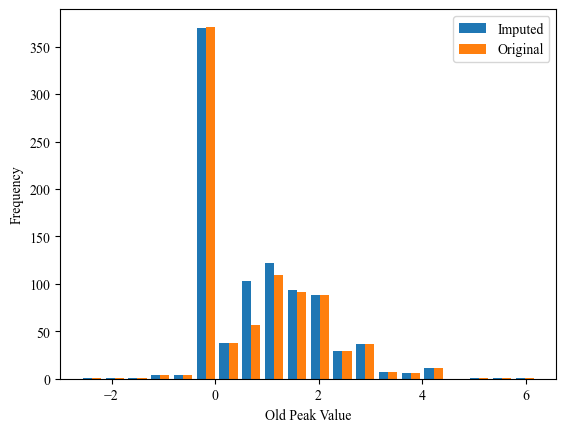

In [9]:
plt.hist([hdnew['oldpeak_imputed'], hd['oldpeak']], bins = 20, label = ['Imputed', 'Original'])
plt.legend()
plt.xlabel('Old Peak Value')
plt.ylabel('Frequency')

# Feature Engineering
The columns `sex`, `fbs`, `exang` and `num` are kept binary, using 0/1 values. The author applied one-hot encoding to the other categorical columns. The numeric columns are standardized. It's shown by some [research](https://pmc.ncbi.nlm.nih.gov/articles/PMC6024687/#:~:text=Cardiovascular%20disease%20(CVD)%20is%20a,increases%20the%20risk%20of%20CVD.) that high cholesterol does not necessarily lead to heart disease. High blood pressure, shown by [research](https://pubmed.ncbi.nlm.nih.gov/31865786/), is a key factor in diagnosis of cardiovascular diseases. The same applies to high rest heart rate  Thus, we decided to create a new column by congregating `age`,  `chol` and `trestbps` to fit num by regression. The result is quite fun: the fit is $\text{age}^{0.59}\text{trestbps}^{-0.36}$, with a very small correlation to `chol` hence we're not considering it.

In [10]:
# adding a new feature that's not fully independent (but cannot be linearly dependent hence fed in NBs)
hdnew['age59bps36'] = hdnew['age'] ** .59 * hdnew['trestbps_imputed'] ** -.36

# dataset
X = hdnew.drop(columns = ['num', ])
y = hdnew['num']
numeric_features = ['age', 'trestbps_imputed', 'chol_imputed', 'thalach_imputed', 'oldpeak_imputed', 'age59bps36']
categorical_features = ['cp', 'restecg', 'slope_imputed', 'thal_imputed']
binary_features = [col + '_na_flag' for col in flag_cols] + ['sex', 'fbs_imputed', 'exang_imputed', 'ca_imputed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# scale numeric features
scaler = StandardScaler()

X_train_num = scaler.fit_transform(X_train[numeric_features])
X_test_num = scaler.transform(X_test[numeric_features])

# one-hot encode categorical features
onehot = OneHotEncoder(drop = None) # not dropping any value, just regular onehot encoding
# if not imputed should have used handle_unknown = 'ignore'
# by setting drop = 'first' or something else we can reduce input dimensions,
# but this should base on that the categories are correlated

X_train_cat = onehot.fit_transform(X_train[categorical_features]).toarray()
X_test_cat = onehot.transform(X_test[categorical_features]).toarray()

# directly store binary features as 0 and 1
X_train_bin = X_train[binary_features].to_numpy()
X_test_bin = X_test[binary_features].to_numpy()

X_train = np.hstack([X_train_num, X_train_cat, X_train_bin])
X_test = np.hstack([X_test_num, X_test_cat, X_test_bin])

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

new_names = numeric_features + [f'cp = {i}' for i in range(1, 5)] + \
    [f'restecg = {i}' for i in range(3)] + [f'slope_imputed = {i}' for i in range(3)] + \
    [f'thal_imputed = {i}' for i in [3,6,7]] + binary_features

# Model Training

## Naive Bayes Classifier (Generative Models)

### Gaussian Naive Bayes

In [11]:
scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

pipe_GNB = Pipeline([('GNB', GaussianNB())])
param_grid_GNB = {'GNB__var_smoothing': [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1]}
grid_GNB = GridSearchCV(estimator = pipe_GNB,
                        param_grid = param_grid_GNB,
                        scoring = scores,
                        cv = 10, # 10-fold cross validation
                        n_jobs = -1,
                        refit = False)
grid_GNB.fit(X_train, y_train)
# print(grid_GNB.cv_results_)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('GNB', GaussianNB())]),
             n_jobs=-1,
             param_grid={'GNB__var_smoothing': [0.001, 0.002, 0.005, 0.01, 0.02,
                                                0.05, 0.1, 0.2, 0.5, 1]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

According to grid_search cv results, $\sigma^2 = 0.05$ returns best result for GaussianNB models

In [12]:
model_GNB = GaussianNB(var_smoothing = 0.05)
model_GNB.fit(X_train, y_train)

GaussianNB(var_smoothing=0.05)

### Bernoulli Naive Bayes

In [13]:
pipe_BNB = Pipeline([('BNB', BernoulliNB())])
param_grid_BNB = {'BNB__alpha': [0.125, 0.25, 0.5, 1, 2, 3, 4, 6, 8, 10, 12, 16, 20]}
grid_BNB = GridSearchCV(pipe_BNB,
                        param_grid = param_grid_BNB,
                        scoring = scores,
                        refit = False,
                        cv = 10,
                        n_jobs = -1)
grid_BNB.fit(X_train, y_train)
# print(grid_BNB.cv_results_)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('BNB', BernoulliNB())]),
             n_jobs=-1,
             param_grid={'BNB__alpha': [0.125, 0.25, 0.5, 1, 2, 3, 4, 6, 8, 10,
                                        12, 16, 20]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

From the results, we know that training with different $\alpha$ does not show significant difference in all metrics. $\alpha=1$ slightly prevailed over others. Thus we decide to use $\alpha = 1$.

In [14]:
model_BNB = BernoulliNB(alpha = 1)
model_BNB.fit(X_train, y_train)

BernoulliNB(alpha=1)

Actually BNB is not taking all the parameters since BNB internally maps anything $>0$ to $1$. This is only appropriate for binary features. But the later evaluation shows it's doing well for some reason.

An potential explanation for this can be, since BNB handles the standardized (normalized) numeric features, thus it just checks whether the numeric is above or below the mean value, which makes sense but doesn't make this model robust enough to handle different datasets.

GNB makes better sense than BNB this way. Moreover, we should define a model that deals with all types of features and see whether it could provide higher generalizability. Multinomial NB does not fit our classification task. Categorical NB is unnecessary since we have one-hot encoded the categorical features.

### Combined Naive Bayes

In [15]:
class MixedNB(BaseEstimator, ClassifierMixin):
    def __init__(self, numeric_cols, binary_cols, var_smoothing = 1e-9, alpha = 1.0, eps = 1e-12):
        if not numeric_cols or not binary_cols:
            raise ValueError('Numeric and Binary features column needs to be specified!')
        self.numeric_cols = numeric_cols
        self.binary_cols = binary_cols
        self.var_smoothing = var_smoothing
        self.alpha = alpha
        self.eps = eps
    
    def fit(self, X, y):
        self.gnb = GaussianNB(var_smoothing = self.var_smoothing)
        self.bnb = BernoulliNB(alpha = self.alpha)
        self.gnb.fit(X[:, self.numeric_cols], y)
        self.bnb.fit(X[:, self.binary_cols], y)
        self.classes_ = np.unique(y)
        return self
    
    def predict_proba(self, X):
        proba = np.ones((X.shape[0], len(self.classes_)))
        proba *= self.gnb.predict_proba(X[:, self.numeric_cols])
        proba *= self.bnb.predict_proba(X[:, self.binary_cols])
        proba += self.eps
        proba /= proba.sum(axis = 1, keepdims = True)
        return proba
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis = 1)

num_counts = len(numeric_features)
model_MNB_ = MixedNB(list(range(num_counts)), list(range(num_counts, X_train.shape[1])))
param_grid_MNB = {'var_smoothing': np.logspace(-3, 0, 4), 'alpha': [1e-2, 1e-1, 1, 2, 5, 10]}
grid_MNB = GridSearchCV(model_MNB_,
                        param_grid = param_grid_MNB,
                        scoring = scores,
                        cv = 10,
                        refit = False,
                        n_jobs = -1)
grid_MNB.fit(X_train, y_train)
# print(grid_MNB.cv_results_)

GridSearchCV(cv=10,
             estimator=MixedNB(binary_cols=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                            16, 17, 18, 19, 20, 21, 22, 23, 24,
                                            25, 26, 27, 28, 29, 30, 31],
                               numeric_cols=[0, 1, 2, 3, 4, 5]),
             n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 2, 5, 10],
                         'var_smoothing': array([0.001, 0.01 , 0.1  , 1.   ])},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

The combined parameters $\alpha=5$ and $\sigma^2=1$ are the best following the result.

In [16]:
model_MNB = MixedNB(list(range(num_counts)), list(range(num_counts, X_train.shape[1])), var_smoothing = 1, alpha = 5)
model_MNB.fit(X_train, y_train)

MixedNB(alpha=5,
        binary_cols=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
                     22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
        numeric_cols=[0, 1, 2, 3, 4, 5], var_smoothing=1)

## Linear Regression (Discrimitative Models)

### Regular Linear Regression

In [17]:
class LinearRegressionBinaryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, threshold = 0.5, **model_params):
        self.model = model
        self.threshold = threshold # maybe also self.model.threshold
        self.model_params = model_params
        
    def fit(self, X, y):
        self.model.fit(X, y)
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        y_pred = self.model.predict(X)
        return (y_pred >= self.threshold).astype(int)
    
    def predict_proba(self, X):
        y_pred = self.model.predict(X)
        y_prob = np.clip(y_pred, 0, 1)
        # If here we use code below rather than above, i.e.
        # y_prob = 1 / (1 + np.exp(- (y_pred - .5)))
        # it'll be a single logistic regression.
        # But this won't make huge impact on ROC curve since both functions
        # used here to transform y_pred to y_prob is increasing and has the
        # threshold 0.5, only those with extreme y_pred (> 1, < 0) would be
        # affected.
        return np.vstack([1 - y_prob, y_prob]).T

model_LR = LinearRegressionBinaryClassifier(LinearRegression())
model_LR.fit(X_train, y_train)

LinearRegressionBinaryClassifier(model=LinearRegression())

### Linear Regression with L1 Regularization

In [18]:
param_grid_LR_Lasso = {'model__alpha': [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 5e-1, 1]}
grid_LR_Lasso = GridSearchCV(LinearRegressionBinaryClassifier(Lasso()),
                       param_grid = param_grid_LR_Lasso,
                       scoring = scores + ['neg_mean_squared_error'],
                       refit = False,
                       cv = 10,
                       n_jobs = -1)
grid_LR_Lasso.fit(X_train, y_train)
# print(grid_LR_Lasso.cv_results_)

GridSearchCV(cv=10, estimator=LinearRegressionBinaryClassifier(model=Lasso()),
             n_jobs=-1,
             param_grid={'model__alpha': [0.001, 0.002, 0.005, 0.01, 0.02, 0.05,
                                          0.1, 0.2, 0.5, 1]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc',
                      'neg_mean_squared_error'])

We can see $\alpha = .01$ overtakes all other in most metrics.

In [19]:
model_LR_Lasso = LinearRegressionBinaryClassifier(Lasso(alpha = .01))
model_LR_Lasso.fit(X_train, y_train)

LinearRegressionBinaryClassifier(model=Lasso(alpha=0.01))

### Linear Regression with L2 Regression

In [20]:
param_grid_LR_Ridge = {'model__alpha': [5, 10, 20, 50, 100, 200, 500]}
grid_LR_Ridge = GridSearchCV(LinearRegressionBinaryClassifier(Ridge()),
                       param_grid = param_grid_LR_Ridge,
                       scoring = scores + ['neg_mean_squared_error'],
                       refit = False,
                       cv = 10,
                       n_jobs = -1)
grid_LR_Ridge.fit(X_train, y_train)
# print(grid_LR_Ridge.cv_results_)

GridSearchCV(cv=10, estimator=LinearRegressionBinaryClassifier(model=Ridge()),
             n_jobs=-1,
             param_grid={'model__alpha': [5, 10, 20, 50, 100, 200, 500]},
             refit=False,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc',
                      'neg_mean_squared_error'])

Confirmed by the cv_results_, $\alpha = 50$ is chosen for our Ridge model.

In [21]:
model_LR_Ridge = LinearRegressionBinaryClassifier(Ridge(alpha = 50))
model_LR_Ridge.fit(X_train, y_train)

LinearRegressionBinaryClassifier(model=Ridge(alpha=50))

# Evaluation

## Comparison over Metrics

In [22]:
cf_test = {}
models = [model_GNB, model_BNB, model_MNB, model_LR, model_LR_Ridge, model_LR_Lasso]
model_names = ['Gaussian NB', 'Bernoulli NB', 'GNB & BNB Combined', 'Linear Regression', 'Ridge (L2 Regularized)', 'Lasso (L1 Regularized)']
evaluation_scores = {}
for metric in scores:
    res = {}
    for i in range(len(models)):
        cv = cross_val_score(models[i], X_test, y_test, cv = 10, scoring = metric)
        res[model_names[i]] = np.average(cv)
    evaluation_scores[metric] = res
evaluation_scores = pd.DataFrame(evaluation_scores)
print(evaluation_scores)

                        accuracy  precision    recall        f1   roc_auc
Gaussian NB             0.803509   0.885783  0.786364  0.829806  0.909794
Bernoulli NB            0.832456   0.863521  0.867424  0.863637  0.901461
GNB & BNB Combined      0.837719   0.858661  0.884848  0.869513  0.889232
Linear Regression       0.799123   0.822161  0.857576  0.837551  0.888420
Ridge (L2 Regularized)  0.821345   0.828765  0.902273  0.861678  0.906602
Lasso (L1 Regularized)  0.777193   0.799456  0.857576  0.823510  0.889069


In [23]:
# for i in range(len(models)):
#     y_pred = models[i].predict(X_test)
#     print(model_names[i] + '\n' + classification_report(y_test, y_pred))

## Confusion Matrices

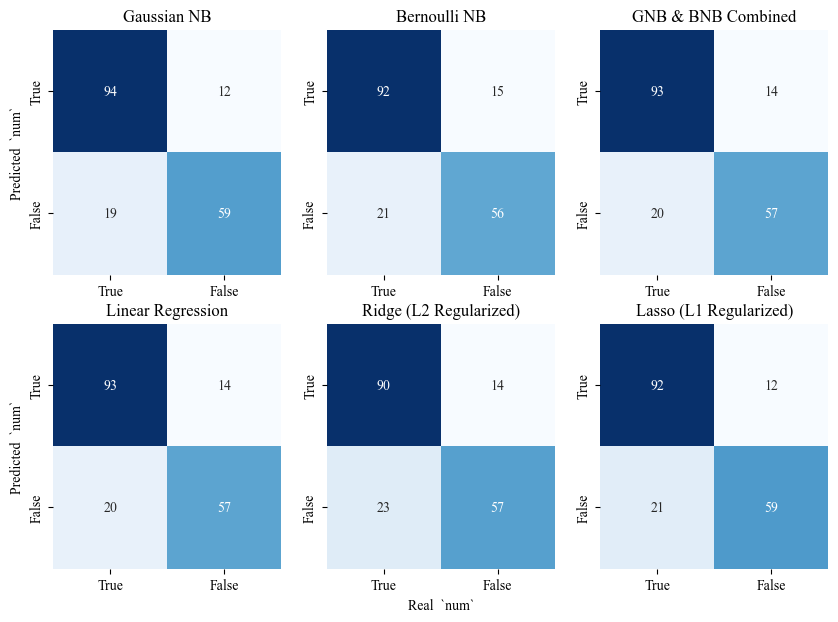

In [24]:
for i in range(len(models)):
    y_pred_test = models[i].predict(X_test)
    cf_test[model_names[i]] = confusion_matrix(1 - y_test, 1 - y_pred_test).T # this is to make sure 0 -> 1 so that cf[0,0] is TP, etc.

fig, axes = plt.subplots(2, 3, figsize=(10,7))

for i in range(len(models)):
    ax = axes[i // 3][i % 3]
    name = model_names[i]
    cm = cf_test[name]
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", cbar = False, ax = ax)
    ax.set_title(name)
    ax.set_yticklabels(['True', 'False'])
    ax.set_xticklabels(['True', 'False'])
    if i == 4:
        ax.set_xlabel("Real  `num`")
    if i % 3 == 0:
        ax.set_ylabel("Predicted  `num`")

## ROC Curves

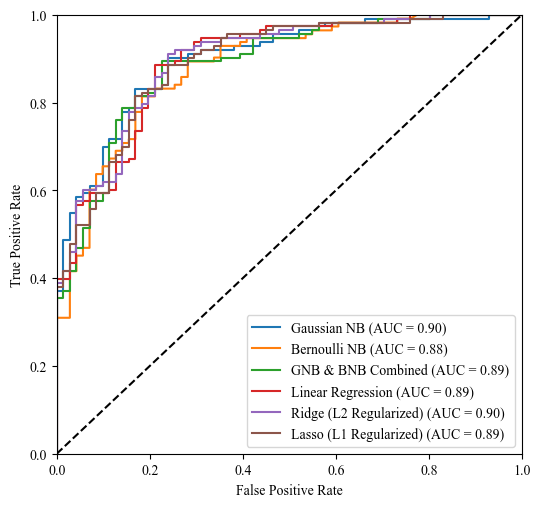

In [25]:
plt.figure(figsize=(6, 5.7))
for name, model in zip(model_names, models):
    y_prob = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {round(roc_auc, 2):.2f})")

plt.plot([0, 1], [0, 1], 'k--') # a random model
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

## Coefficient Interpretation in Discriminative Models

In [26]:
# coefficients of Lasso
print(np.vstack([new_names, model_LR_Lasso.model.coef_]).T)

[['age' '0.030784841047794793']
 ['trestbps_imputed' '0.003937668364791211']
 ['chol_imputed' '0.0010452258743032495']
 ['thalach_imputed' '-0.028052094579908652']
 ['oldpeak_imputed' '0.051259590424525756']
 ['age59bps36' '0.0']
 ['cp = 1' '-0.0']
 ['cp = 2' '-0.0280651181775137']
 ['cp = 3' '0.0']
 ['cp = 4' '0.22962284530483734']
 ['restecg = 0' '0.0']
 ['restecg = 1' '0.0']
 ['restecg = 2' '-0.0']
 ['slope_imputed = 0' '-0.06448122941695207']
 ['slope_imputed = 1' '0.03734087432618617']
 ['slope_imputed = 2' '-0.0']
 ['thal_imputed = 3' '-0.006673502560206314']
 ['thal_imputed = 6' '0.0']
 ['thal_imputed = 7' '0.06095405756555691']
 ['trestbps_na_flag' '0.0']
 ['chol_na_flag' '0.10264991851408072']
 ['fbs_na_flag' '0.05009718321918432']
 ['thalach_na_flag' '0.0']
 ['exang_na_flag' '0.0']
 ['oldpeak_na_flag' '0.0']
 ['slope_na_flag' '-0.050055055563975895']
 ['ca_na_flag' '0.008707685204772693']
 ['thal_na_flag' '-0.0']
 ['sex' '0.13902201664161518']
 ['fbs_imputed' '0.0']
 ['exang_

The Lasso model gives us an intuition that if someone is male, having asymptotic chest pain, exercise induced pain, lower maximum heart rate achieved, positive (higher) ST depression induced by exercise relative to rest, and higher ca, then this one is more likely to have heart disease than not. Though, the chol column NA flag is given a positive coefficient, which is counter-intuitive. Also, we can check Ridge and Regular LRs' coefficients.

In [27]:
print(np.vstack([new_names, model_LR_Ridge.model.coef_]).T)

[['age' '0.02647745021411741']
 ['trestbps_imputed' '0.009936862335389532']
 ['chol_imputed' '0.01002366858156039']
 ['thalach_imputed' '-0.028052627748990026']
 ['oldpeak_imputed' '0.04965454823234647']
 ['age59bps36' '0.003274241273249591']
 ['cp = 1' '-0.02458819206494186']
 ['cp = 2' '-0.0911350863812643']
 ['cp = 3' '-0.04115356759267366']
 ['cp = 4' '0.15687684603887642']
 ['restecg = 0' '0.0028617378324886917']
 ['restecg = 1' '-0.005802468424827636']
 ['restecg = 2' '0.0029407305923382057']
 ['slope_imputed = 0' '-0.05569815238118739']
 ['slope_imputed = 1' '0.056853044676525036']
 ['slope_imputed = 2' '-0.0011548922953368926']
 ['thal_imputed = 3' '-0.0415402940511684']
 ['thal_imputed = 6' '-0.024881896729255025']
 ['thal_imputed = 7' '0.06642219078042498']
 ['trestbps_na_flag' '0.019943770156627485']
 ['chol_na_flag' '0.09014366524352993']
 ['fbs_na_flag' '0.09556341498829474']
 ['thalach_na_flag' '0.007810512037514863']
 ['exang_na_flag' '0.007810512037514861']
 ['oldpeak_n

In [28]:
print(np.vstack([new_names, model_LR.model.coef_]).T)

[['age' '0.22219320799888145']
 ['trestbps_imputed' '-0.07918289699926444']
 ['chol_imputed' '0.004760943636994989']
 ['thalach_imputed' '-0.01127851450308369']
 ['oldpeak_imputed' '0.03659713094258367']
 ['age59bps36' '-0.1930296212488057']
 ['cp = 1' '-0.04849123307908245']
 ['cp = 2' '-0.09846535802160895']
 ['cp = 3' '-0.03744646887960671']
 ['cp = 4' '0.18440305998029824']
 ['restecg = 0' '0.002147494044804484']
 ['restecg = 1' '-0.01719587316257471']
 ['restecg = 2' '0.015048379117770584']
 ['slope_imputed = 0' '-0.05833358441440159']
 ['slope_imputed = 1' '0.06855481653148433']
 ['slope_imputed = 2' '-0.010221232117082245']
 ['thal_imputed = 3' '-0.02934539404721061']
 ['thal_imputed = 6' '-0.044740136079504896']
 ['thal_imputed = 7' '0.07408553012671538']
 ['trestbps_na_flag' '0.22857979517808105']
 ['chol_na_flag' '0.07158092119051071']
 ['fbs_na_flag' '0.1741288488855073']
 ['thalach_na_flag' '-0.1081421083582322']
 ['exang_na_flag' '-0.10814210835823236']
 ['oldpeak_na_flag'

## Sensitivity of Model Coefficient

In [29]:
# how coefficient affects performance on test dataset - prepare (training a lot of models)
grid_results = {'Gaussian NB': {metric: [] for metric in scores}, 
                'Bernoulli NB': {metric: [] for metric in scores}, 
                'Ridge (L2 Regularized)': {metric: [] for metric in scores + ['neg_mean_squared_error', 'mean_squared_error']}, 
                'Lasso (L1 Regularized)': {metric: [] for metric in scores + ['neg_mean_squared_error', 'mean_squared_error']}}
grid_errors = {'Gaussian NB': {metric: [] for metric in scores}, 
                'Bernoulli NB': {metric: [] for metric in scores}, 
                'Ridge (L2 Regularized)': {metric: [] for metric in scores + ['neg_mean_squared_error', 'mean_squared_error']}, 
                'Lasso (L1 Regularized)': {metric: [] for metric in scores + ['neg_mean_squared_error', 'mean_squared_error']}}
xes = [np.logspace(-4, 1, 51), np.logspace(-2, 2, 41), np.logspace(-0.2, 3, 33), np.logspace(-3.2, 0, 33)]
# GNB
for var in np.logspace(-4, 1, 51):
    gnb = GaussianNB(var_smoothing = var)
    gnb.fit(X_train, y_train)
    for metric in scores:
        score = cross_val_score(gnb, X_test, y_test, scoring = metric)
        grid_results['Gaussian NB'][metric].append(np.average(score))
        grid_errors['Gaussian NB'][metric].append(np.std(score))
# BNB
for alpha in np.logspace(-2, 2, 41):
    bnb = BernoulliNB(alpha = alpha)
    bnb.fit(X_train, y_train)
    for metric in scores:
        score = cross_val_score(bnb, X_test, y_test, scoring = metric)
        grid_results['Bernoulli NB'][metric].append(np.average(score))
        grid_errors['Bernoulli NB'][metric].append(np.std(score))
# Ridge
for alpha in np.logspace(-0.2, 3, 33):
    ridge = LinearRegressionBinaryClassifier(Ridge(alpha = alpha))
    ridge.fit(X_train, y_train)
    for metric in scores + ['neg_mean_squared_error']:
        score = cross_val_score(ridge, X_test, y_test, scoring = metric)
        grid_results['Ridge (L2 Regularized)'][metric].append(np.average(score))
        grid_errors['Ridge (L2 Regularized)'][metric].append(np.std(score))
        if metric == 'neg_mean_squared_error':
            grid_results['Ridge (L2 Regularized)']['mean_squared_error'].append(1 + np.average(score))
            grid_errors['Ridge (L2 Regularized)']['mean_squared_error'].append(np.std(score))
# Lasso
for alpha in np.logspace(-3.2, 0, 33):
    lasso = LinearRegressionBinaryClassifier(Lasso(alpha = alpha))
    lasso.fit(X_train, y_train)
    for metric in scores + ['neg_mean_squared_error']:
        score = cross_val_score(lasso, X_test, y_test, scoring = metric)
        grid_results['Lasso (L1 Regularized)'][metric].append(np.average(score))
        grid_errors['Lasso (L1 Regularized)'][metric].append(np.std(score))
        if metric == 'neg_mean_squared_error':
            grid_results['Lasso (L1 Regularized)']['mean_squared_error'].append(1 + np.average(score))
            grid_errors['Lasso (L1 Regularized)']['mean_squared_error'].append(np.std(score))

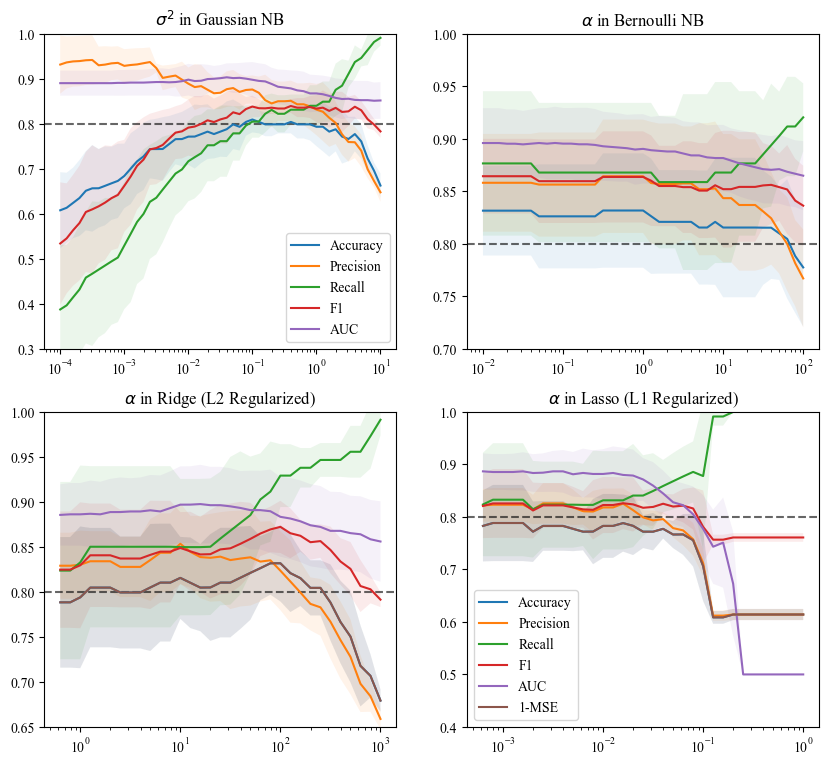

In [30]:
# how coefficient affects performance on test dataset
grid_names = ['Gaussian NB', 'Bernoulli NB', 'Ridge (L2 Regularized)', 'Lasso (L1 Regularized)']
grid_param_names = [r'$\sigma^2$'] + [r'$\alpha$'] * 3
legends = {'accuracy': 'Accuracy', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1', 'roc_auc': 'AUC', 'mean_squared_error': '1-MSE'}

fig, axes = plt.subplots(2, 2, figsize=(10,9))

for i in range(4):
    ax = axes[i // 2][i % 2]
    name = grid_names[i]
    cv = grid_results[name]
    err = grid_errors[name]
    x = xes[i]
    ax.set_xscale('log')
    ax.set_title(grid_param_names[i] + ' in ' + name)
    ax.set_ylim(([0.3, 0.7, 0.65, 0.4][i],1.0))
    ax.axhline(y = 0.8, color = 'black', alpha = 0.6, linestyle = '--')

    for metric in cv.keys():
        if metric == 'neg_mean_squared_error':
            continue
        y = np.array(cv[metric])
        yerr = np.array(err[metric])
        ax.plot(x, y, label = legends[metric])
        ax.fill_between(x, y + yerr, y - yerr, alpha = .09)
    if i == 0: ax.legend(loc = 'lower right')
    if i == 3: ax.legend(loc = 'lower left')